<a href="https://colab.research.google.com/github/AlexRapoport2000/dissertation/blob/main/7parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.4


In [ ]:
%load_ext watermark
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

ModuleNotFoundError: No module named 'watermark'

In [ ]:
from google.colab import files
upload = files.upload()

Saving data.xlsx to data.xlsx


In [ ]:
import io
data = pd.read_excel(io.BytesIO(upload['data.xlsx']))
data.head()

,year,lynx,hare,wolf
0,0.00,10.000000,10.000000,10.000000
1,0.04,10.092373,9.989272,10.000979
2,0.08,10.185146,9.977728,10.002077
3,0.12,10.278280,9.965367,10.003294
4,0.16,10.371733,9.952190,10.004630


In [ ]:
# fmt: off
data = pd.DataFrame(dict(
    year = np.arange(0., 13.2, 0.04),
    lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
    hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7]),
    wolf = np.array([43.0, 66.2, 57.2, 74.4, 19.3, 21.6, 22.1, 3.4, 38.0, 22.4, 11.1, 33.3,
57.0, 94.6, 68.3, 15.5, 17.2, 7.6, 29.6, 19.2, 35.7])))
data.head()
# fmt: on

ValueError: All arrays must be of the same length

In [ ]:
data.lynx[1::2]

1      10.092373
3      10.278280
5      10.465465
7      10.653589
9      10.842295
         ...    
321     5.543301
323     5.603113
325     5.666066
327     5.732221
329     5.801635
Name: lynx, Length: 165, dtype: float64

In [ ]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="Исходные данные"):
    ax.plot(data.year[0::5], data.hare[0::5], color="g", lw=lw, marker="+", markersize=7, label="Эпителиальные клетки X")
    ax.plot(data.year[0::5], data.lynx[0::5], color="b", lw=lw, marker="o", markersize=5, label="Кандида Y")
    ax.plot(data.year[0::5], data.wolf[0::5], color="r", lw=lw, marker="*", markersize=9, label="Бактерии стрептококков Z")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([0, 13.2])
    ax.set_ylim(0)
    ax.set_xlabel("Время, часы", fontsize=14)
    ax.set_ylabel("Кол-во клеток", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)
    return ax

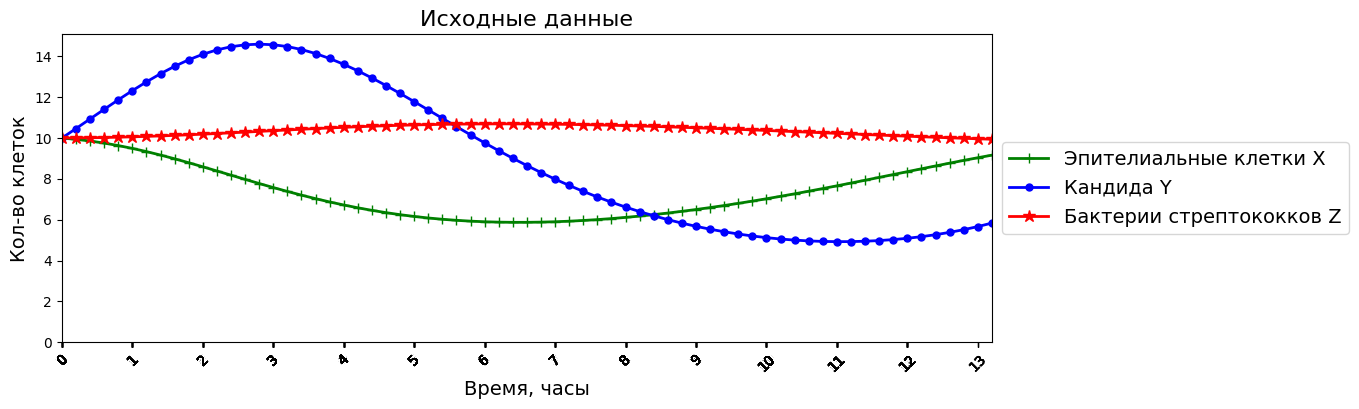

In [ ]:
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax);

In [ ]:
# define the right hand side of the ODE equations in the Scipy odeint signature
from numba import njit


@njit
def rhs(X, t, theta):
    # unpack parameters
    x, y, z = X
    alpha, beta, gamma, delta, nq, eps, fi, xt0, yt0, zt0 = theta
    # equations
    dx_dt = alpha * x - beta * x * y
    dy_dt = -gamma * y + delta * x * y - nq* y * z
    dz_dt = -eps * z + fi * y * z
    return [dx_dt, dy_dt, dz_dt]

In [ ]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=np.arange(0, 13.2, 0.04),
    alpha=1,
    lw=3,
    title="Hudson's Bay Company Data and\nExample Model Run",
):
    ax.plot(time, x_y[:, 0], color="g", alpha=alpha, lw=lw, label="Эпителиальные клетки X (решение)")
    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Кандида Y (решение)")
    ax.plot(time, x_y[:, 2], color="r", alpha=alpha, lw=lw, label="Бактерии стрептококков Z (решение)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

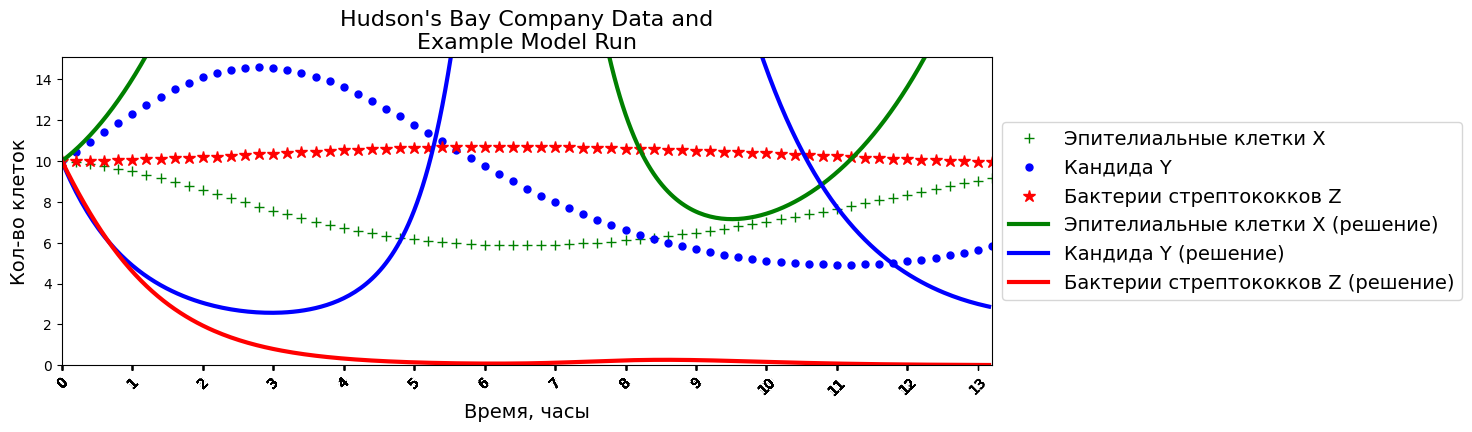

In [ ]:
# note theta = alpha, beta, gamma, delta, nq, eps, fi, xt0, yt0, zt0
theta = np.array([0.52, 0.026, 0.84, 0.026, 0.026, 0.96, 0.026, 10, 10, 10])
time = np.arange(0, 13.2, 0.04)

# call Scipy's odeint function4
x_y = odeint(func=rhs, y0=theta[-3:], t=time, args=(theta,))
# plot
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y);

In [ ]:
# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    return (
        data[["hare", "lynx", "wolf" ]] - odeint(func=rhs, y0=theta[-3:], t=data.year, args=(theta,))
    ).values.flatten()

In [ ]:
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, x0=theta)

# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = ["alpha", "beta", "gamma", "delta", "nq","eps", "fi","x0", "y0", "z0"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results.x
df.round(2)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


,Parameter,Least Squares Solution
0,alpha,0.20
1,beta,0.02
2,gamma,0.06
3,delta,0.09
4,nq,0.07
5,eps,0.03
6,fi,0.00
7,x0,10.00
8,y0,10.00
9,z0,10.00


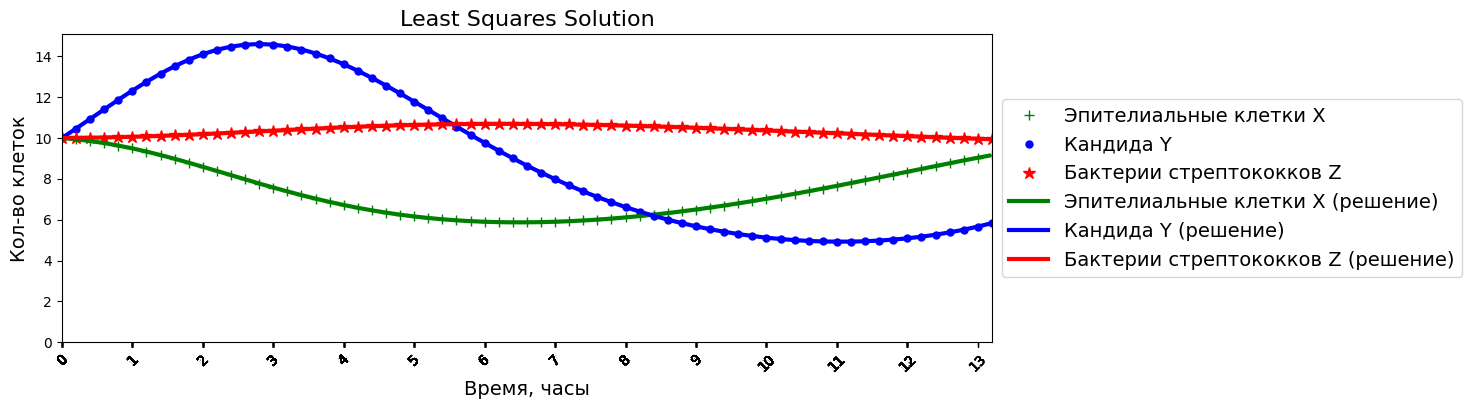

In [ ]:
time = np.arange(0, 13.2, 0.04)
theta = results.x
x_y = odeint(func=rhs, y0=theta[-3:], t=time, args=(theta,))
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y, title="Least Squares Solution");

In [ ]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=theta[-3:], t=data.year, args=(theta,))


In [ ]:
theta = results.x  # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=-1, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=-1, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=-1, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=-1, initval=theta[3])
    nq = pm.TruncatedNormal("nq", mu=theta[4], sigma=0.01, lower=-1, initval=theta[4])
    eps = pm.TruncatedNormal("eps", mu=theta[5], sigma=0.1, lower=-1, initval=theta[5])
    fi = pm.TruncatedNormal("fi", mu=theta[6], sigma=0.01, lower=-1, initval=theta[6])
    xt0 = pm.TruncatedNormal("xto", mu=theta[7], sigma=1, lower=-1, initval=theta[7])
    yt0 = pm.TruncatedNormal("yto", mu=theta[8], sigma=1, lower=-1, initval=theta[8])
    zt0 = pm.TruncatedNormal("zto", mu=theta[9], sigma=1, lower=-1, initval=theta[9])
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([alpha, beta, gamma, delta, nq, eps, fi, xt0, yt0, zt0])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx","wolf"]].values)

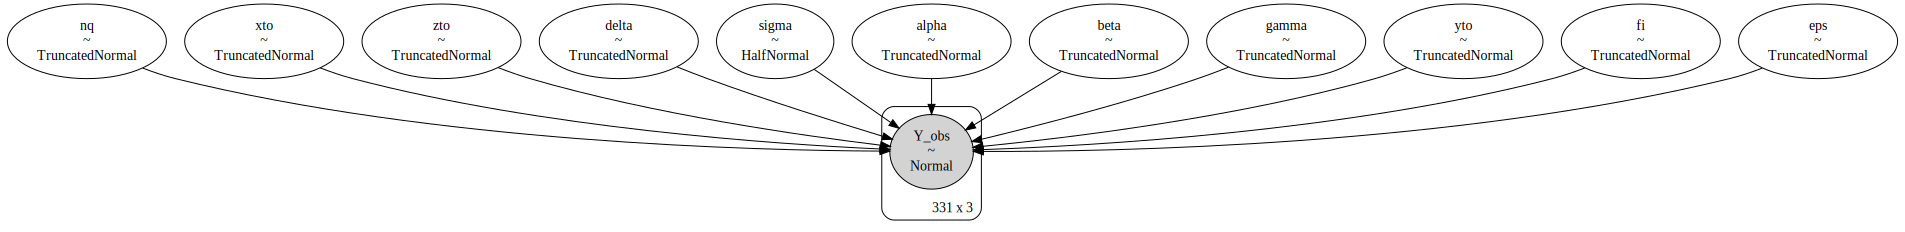

In [ ]:
pm.model_to_graphviz(model=model)

In [ ]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["alpha", "beta", "gamma", "delta", "nq", "eps", "fi", "xto", "yto", "zto"]
    row = trace_df.iloc[row_idx, :][cols].values

    # alpha, beta, gamma, delta, Xt0, Yt0
    time = np.arange(0, 13.2, 0.04)
    theta = row
    x_y = odeint(func=rhs, y0=theta[-3:], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [ ]:
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hudson's Bay Company Data and\nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:3], labels[:3], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

In [ ]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]


In [ ]:
# Specify the sampler
sampler = "Slice Sampler"
tune = draws = 500

# Inference!
with model:
    trace_slice = pm.sample(step=[pm.Slice(vars_list)], tune=tune, draws=draws)
trace = trace_slice
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.195,0.011,0.178,0.219,0.006,0.005,4.0,12.0,1.55
beta,0.022,0.001,0.020,0.025,0.001,0.000,4.0,11.0,1.56
gamma,0.061,0.039,0.000,0.120,0.026,0.021,3.0,17.0,2.18
delta,0.096,0.003,0.089,0.102,0.002,0.001,4.0,12.0,1.42
nq,0.066,0.004,0.061,0.073,0.003,0.002,3.0,16.0,1.86
eps,0.029,0.005,0.019,0.037,0.003,0.002,4.0,38.0,1.50
fi,0.003,0.001,0.002,0.004,0.000,0.000,4.0,49.0,1.48
xto,9.959,0.132,9.712,10.223,0.054,0.040,6.0,19.0,1.27
yto,9.972,0.139,9.708,10.214,0.015,0.010,93.0,172.0,1.03
zto,10.032,0.111,9.816,10.234,0.015,0.011,54.0,105.0,1.06


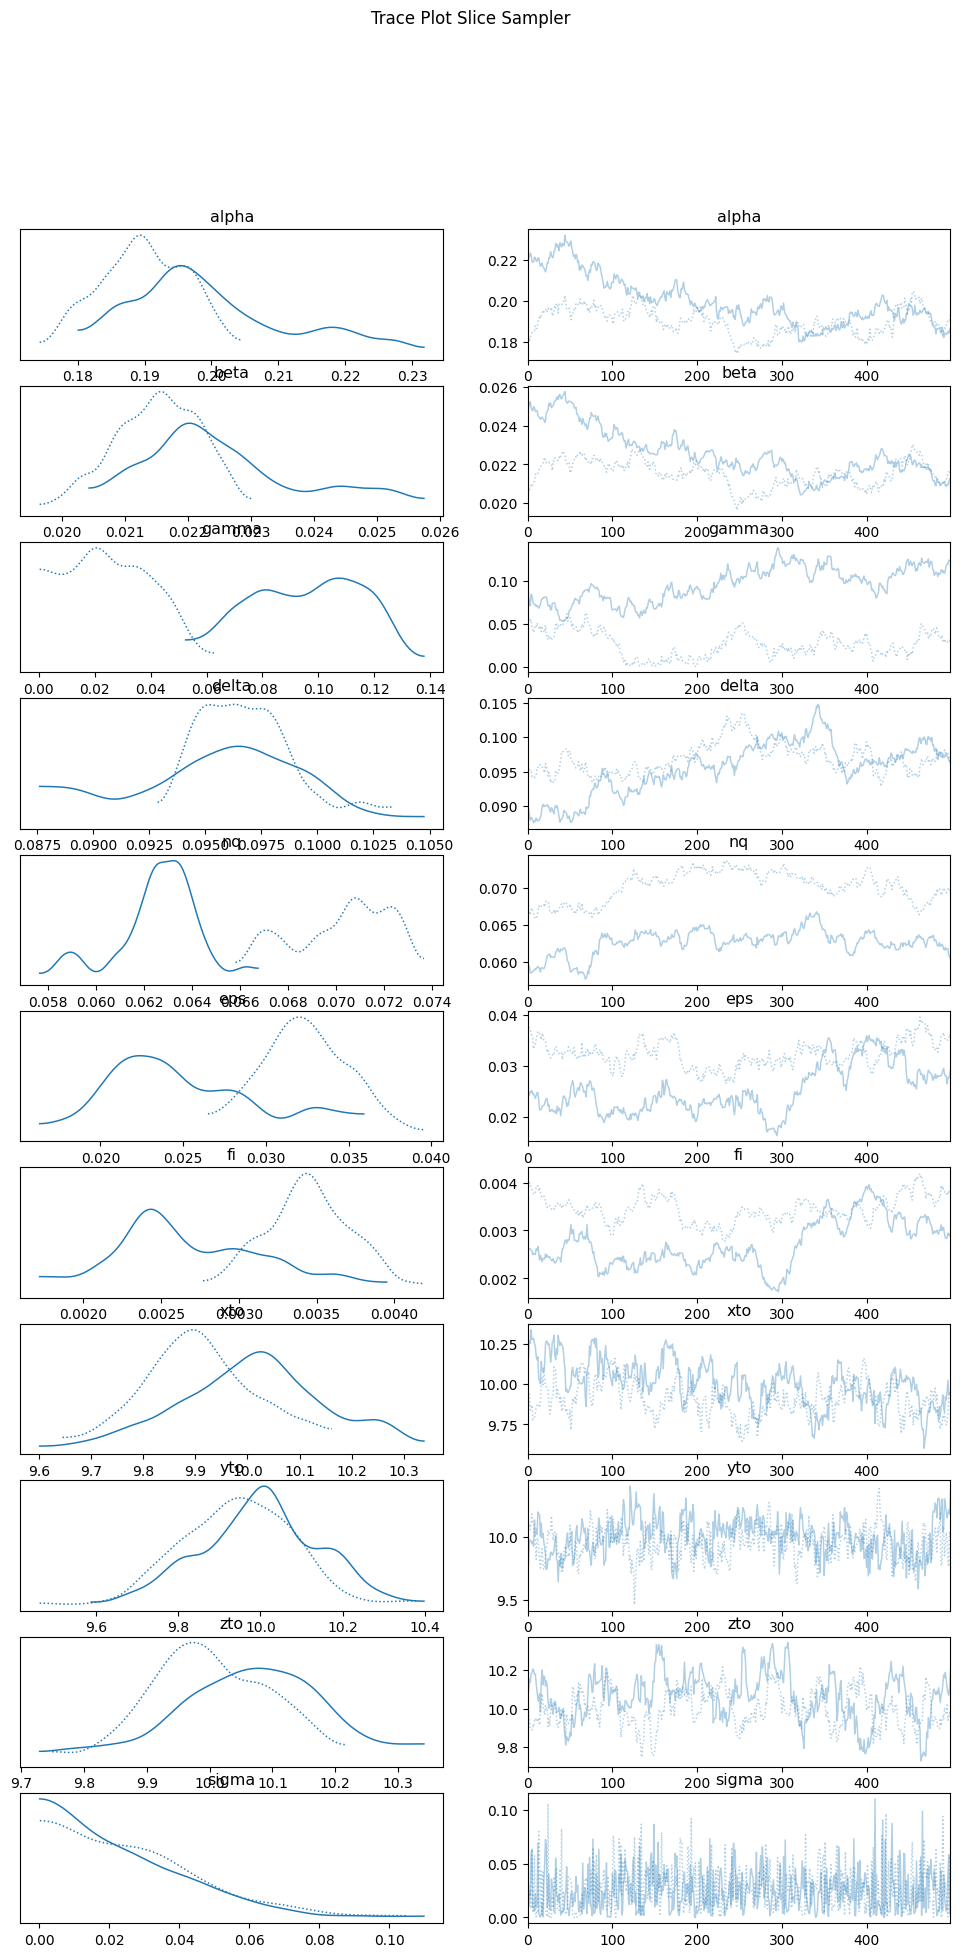

In [ ]:
az.plot_trace(trace, compact=True)
plt.suptitle(f"Trace Plot {sampler}");

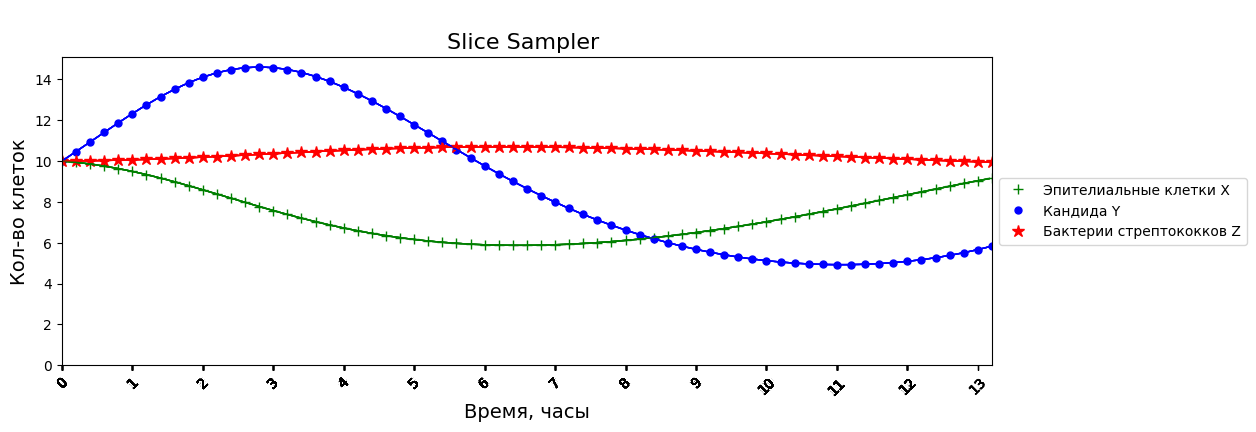

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"\n{sampler} ");

In [ ]:
sampler = "DEMetropolisZ"
tune = draws = 15000
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws)
trace = trace_DEMZ
az.summary(trace)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.356,0.329,-0.125,0.750,0.229,0.192,3.0,12.0,2.23
beta,0.039,0.033,-0.011,0.077,0.023,0.019,3.0,11.0,2.19
gamma,-0.411,0.299,-0.617,0.211,0.200,0.174,3.0,11.0,2.25
delta,0.041,0.016,0.023,0.069,0.009,0.007,4.0,36.0,1.46
nq,0.082,0.028,0.030,0.112,0.019,0.016,2.0,11.0,2.35
eps,-0.233,0.190,-0.403,0.096,0.133,0.113,3.0,17.0,2.30
fi,-0.023,0.018,-0.038,0.011,0.013,0.011,2.0,18.0,2.48
xto,9.739,1.368,7.163,12.141,0.740,0.597,3.0,11.0,1.94
yto,10.969,2.978,8.508,17.185,2.004,1.663,3.0,11.0,1.81
zto,10.271,2.963,7.989,16.294,2.015,1.680,2.0,13.0,2.74


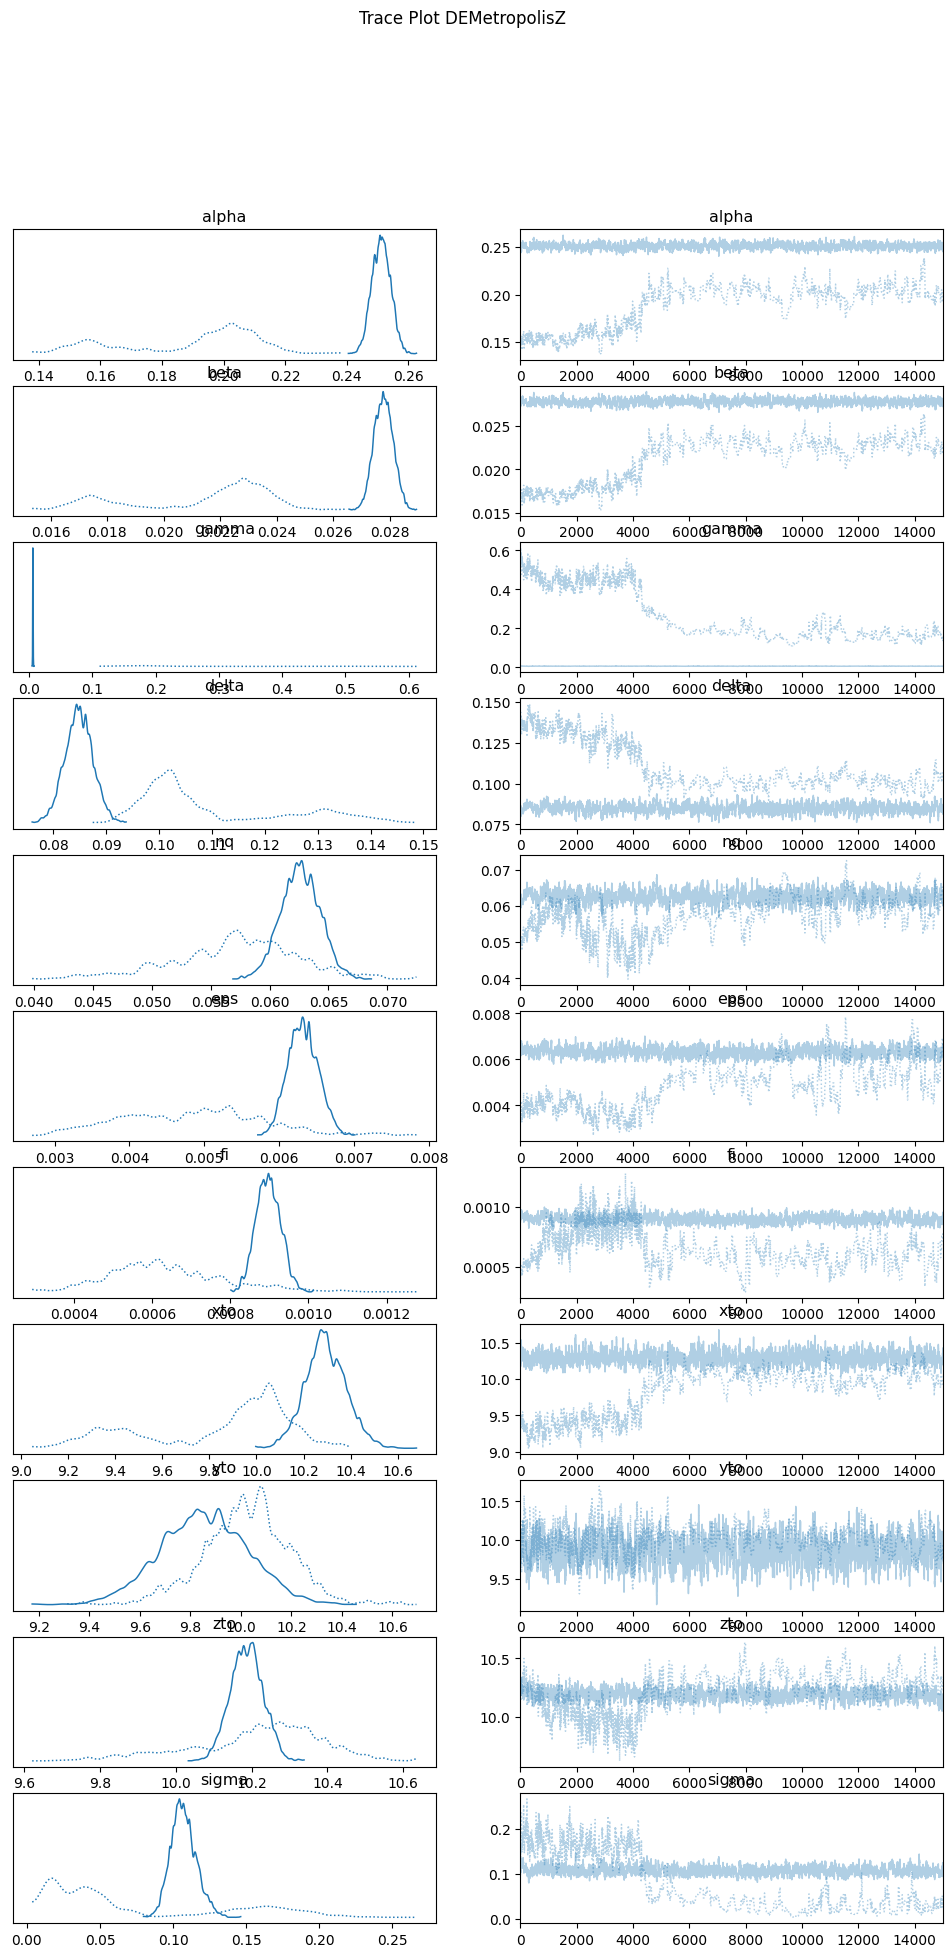

In [ ]:
az.plot_trace(trace, compact=True)
plt.suptitle(f"Trace Plot {sampler}");

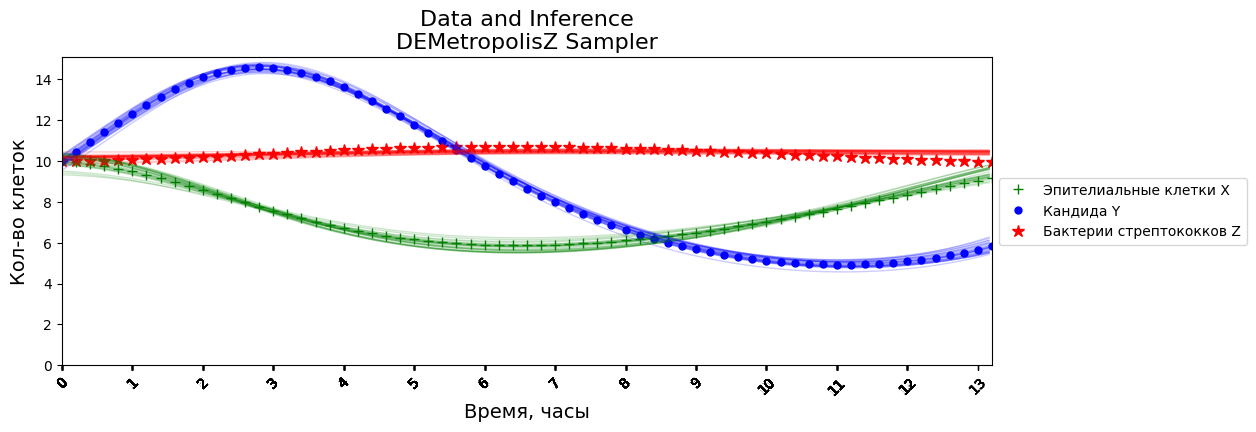

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference\n{sampler} Sampler")

In [ ]:
# simulator function based on the signature rng, parameters, size.
def simulator_forward_model(rng, alpha, beta, gamma, delta, nq, eps, fi, xt0, yt0, zt0, sigma, size=None):
    theta = alpha, beta, gamma, delta, nq, eps, fi, xt0, yt0, zt0
    mu = odeint(func=rhs, y0=theta[-3:], t=data.year, args=(theta,))
    return rng.normal(mu, sigma)

In [ ]:
with pm.Model() as model:
    # Specify prior distributions for model parameters
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    nq = pm.TruncatedNormal("nq", mu=theta[4], sigma=0.01, lower=0, initval=theta[4])
    eps = pm.TruncatedNormal("eps", mu=theta[5], sigma=0.1, lower=0, initval=theta[5])
    fi = pm.TruncatedNormal("fi", mu=theta[6], sigma=0.01, lower=0, initval=theta[6])
    xt0 = pm.TruncatedNormal("xto", mu=theta[7], sigma=1, lower=0, initval=theta[7])
    yt0 = pm.TruncatedNormal("yto", mu=theta[8], sigma=1, lower=0, initval=theta[8])
    zt0 = pm.TruncatedNormal("zto", mu=theta[9], sigma=1, lower=0, initval=theta[9])
    sigma = pm.HalfNormal("sigma", 10)


    # ode_solution
    pm.Simulator(
        "Y_obs",
        simulator_forward_model,
        params=(alpha, beta, gamma, delta, nq, eps, fi, xt0, yt0, zt0, sigma),
        epsilon=1,
        observed=data[["hare", "lynx", "wolf"]].values,
    )

In [ ]:
sampler = "SMC_epsilon=1"
draws = 500
with model:
    trace_SMC_e1 = pm.sample_smc(draws=draws, progressbar=False)
trace = trace_SMC_e1
az.summary(trace)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.198,0.009,0.181,0.214,0.000,0.000,809.0,920.0,1.00
beta,0.022,0.001,0.021,0.024,0.000,0.000,814.0,826.0,1.00
gamma,0.082,0.032,0.028,0.136,0.001,0.001,691.0,444.0,1.01
delta,0.094,0.004,0.087,0.103,0.000,0.000,945.0,890.0,1.00
nq,0.063,0.004,0.056,0.070,0.000,0.000,925.0,513.0,1.00
eps,0.029,0.006,0.018,0.041,0.000,0.000,989.0,855.0,1.00
fi,0.003,0.001,0.002,0.004,0.000,0.000,966.0,854.0,1.00
xto,10.001,0.139,9.724,10.253,0.005,0.003,913.0,834.0,1.00
yto,9.993,0.153,9.701,10.276,0.006,0.004,743.0,980.0,1.00
zto,10.002,0.117,9.782,10.216,0.004,0.003,887.0,946.0,1.00


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


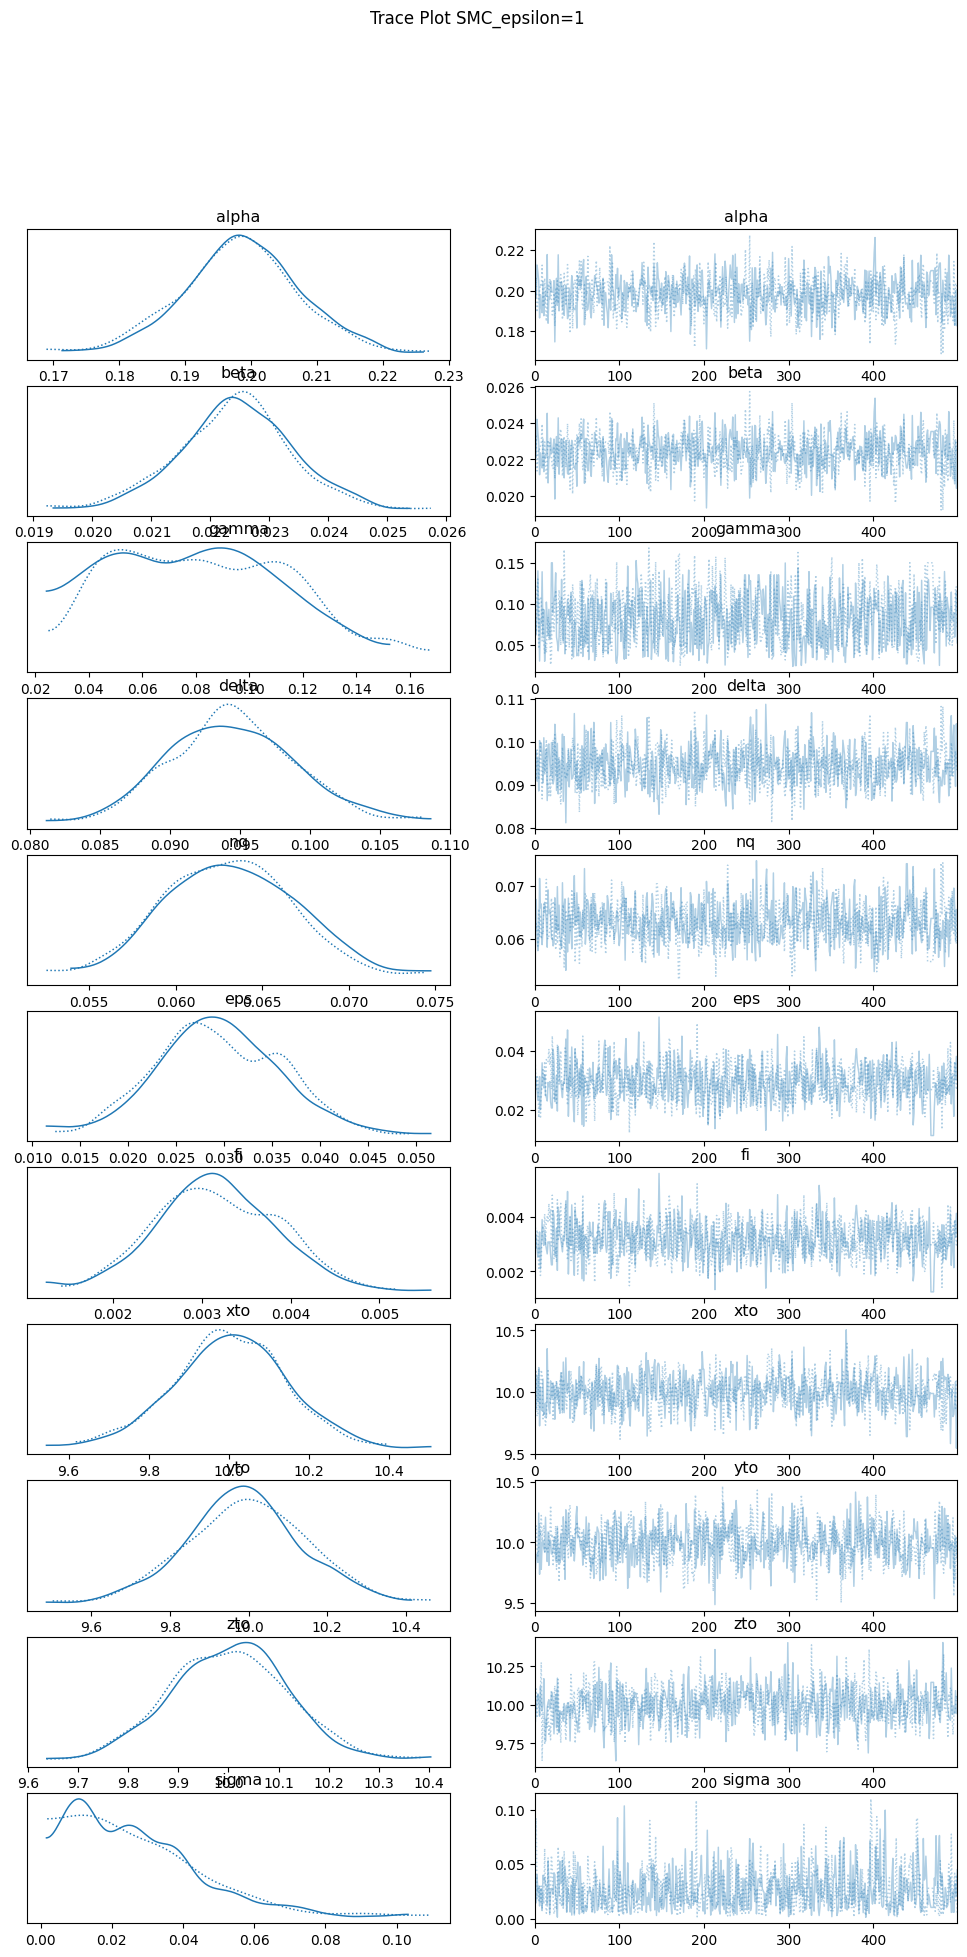

In [ ]:
az.plot_trace(trace)
plt.suptitle(f"Trace Plot {sampler}");

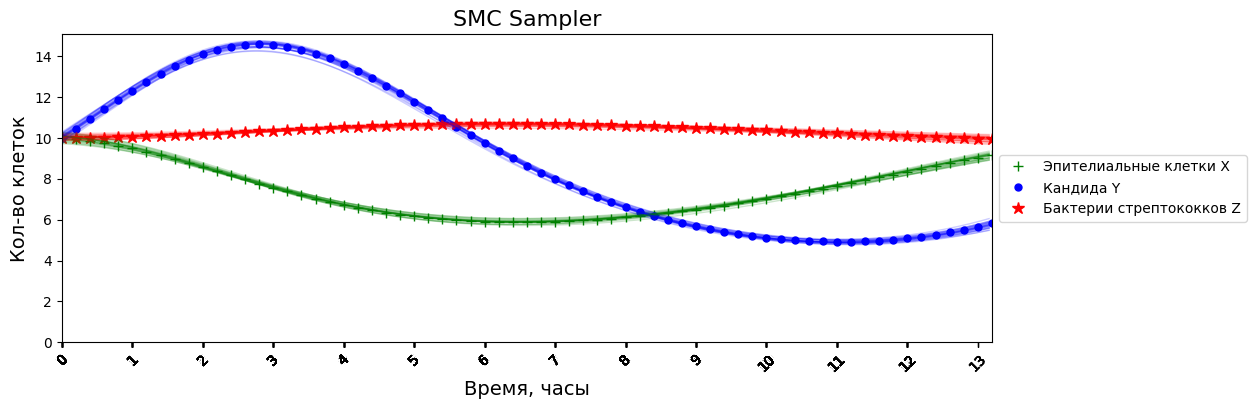

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"SMC Sampler");